In [1]:
"""
The following is code created for the final project in ECGR 4105 Intro to Machine Learning.  
Our project was the prediction of Engineering graduate salaries.  
Team Members
Evan Hodge ID# 800986621
"""

In [1]:
import torch

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Take in the data frame and the column we want to encode
def onehot_encode(df, column):
    
    # create copy of the data frame
    df = df.copy()
    
    # Create the dummies
    dummies = pd.get_dummies(df[column], prefix=column)
    
    # put dummies onto the data frame
    df = pd.concat([df, dummies], axis=1)
    
    df = df.drop(column, axis=1)
    
    return df

In [4]:
import pandas as pd 
import numpy as np 
import torch.optim as optim
EGS = pd.read_csv('Engineering_graduate_salary.csv')
EGS.head()

,ID,Gender,DOB,10percentage,10board,12graduation,12percentage,12board,CollegeID,CollegeTier,...,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience,Salary
0,604399,f,10/22/1990,87.80,cbse,2009,84.00,cbse,6920,1,...,-1,-1,-1,-1,-0.1590,0.3789,1.2396,0.14590,0.2889,445000
1,988334,m,5/15/1990,57.00,cbse,2010,64.50,cbse,6624,2,...,-1,-1,-1,-1,1.1336,0.0459,1.2396,0.52620,-0.2859,110000
2,301647,m,8/21/1989,77.33,"maharashtra state board,pune",2007,85.17,amravati divisional board,9084,2,...,-1,-1,260,-1,0.5100,-0.1232,1.5428,-0.29020,-0.2875,255000
3,582313,m,5/4/1991,84.30,cbse,2009,86.00,cbse,8195,1,...,-1,-1,-1,-1,-0.4463,0.2124,0.3174,0.27270,0.4805,420000
4,339001,f,10/30/1990,82.00,cbse,2008,75.00,cbse,4889,2,...,-1,-1,-1,-1,-1.4992,-0.7473,-1.0697,0.06223,0.1864,200000


In [5]:
#EGS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     2998 non-null   int64  
 1   Gender                 2998 non-null   object 
 2   DOB                    2998 non-null   object 
 3   10percentage           2998 non-null   float64
 4   10board                2998 non-null   object 
 5   12graduation           2998 non-null   int64  
 6   12percentage           2998 non-null   float64
 7   12board                2998 non-null   object 
 8   CollegeID              2998 non-null   int64  
 9   CollegeTier            2998 non-null   int64  
 10  Degree                 2998 non-null   object 
 11  Specialization         2998 non-null   object 
 12  collegeGPA             2998 non-null   float64
 13  CollegeCityID          2998 non-null   int64  
 14  CollegeCityTier        2998 non-null   int64  
 15  Coll

In [6]:
num_vars = ['collegeGPA','Gender','MechanicalEngg', 'ElectricalEngg', 'CivilEngg','Salary'] # define binary attributes

EGS['Gender'] = EGS['Gender'].replace({'f': 0, 'm': 1})
#for column in [ 'Degree', 'Specialization']:
#    EGS = onehot_encode(EGS, column)

EGS = EGS[num_vars]


X = EGS.loc[:, EGS.columns != 'Salary']
Y = EGS.iloc[:,-1:]



from sklearn.preprocessing import MinMaxScaler, StandardScaler   #Scale Training and test sets
#sc_X = StandardScaler()              
sc_X = MinMaxScaler()      # Better TruePositive results were obtained using min/max scaling         

X = pd.DataFrame(sc_X.fit_transform(X))
Y = pd.DataFrame(sc_X.fit_transform(Y))

X_df = X
Y_df = Y

X = np.array(X)
Y = np.array(Y)

t_u = torch.tensor(X, dtype=torch.float32)
t_c = torch.tensor(Y, dtype=torch.float32)

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u


In [21]:

import torch.nn as nn
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(5,8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))]))
#seq_model = nn.Sequential(
#    nn.Linear(5, 8),
#    nn.Tanh(),
#    nn.Linear(8, 1))
seq_model

[param.shape for param in seq_model.parameters()]
numel_list = [p.numel() 
              for p in seq_model.parameters()
              if p.requires_grad == True]
print(sum(numel_list), numel_list)

for name, param in seq_model.named_parameters():
    print(name, param.shape)

learning_rate=1e-2

optimizer = optim.SGD(seq_model.parameters(), lr=learning_rate)

tloss = torch.ones((200))
vloss = torch.ones((200))

def training_loop(n_epochs, optimizer, seq_model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        
        t_p_train = seq_model(t_u_train)
        train_loss = loss_fn(t_p_train, t_c_train)
        
        t_p_val = seq_model(t_u_val)
        val_loss = loss_fn(t_p_val, t_c_val)

        tloss[epoch-1] = train_loss
        vloss[epoch-1] = val_loss
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch ==1 or epoch % 200 == 0:
            print(f"Epoch {epoch}, training loss {train_loss.item():.4f},"f" Validation loss {val_loss.item():.4f}")

57 [40, 8, 8, 1]
hidden_linear.weight torch.Size([8, 5])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [11]:
training_loop(
    n_epochs = 200,
    optimizer = optimizer,
    seq_model =  seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c)
#print('output', seq_model(val_t_un))
#print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)
    

Epoch 1, training loss 0.0295, Validation loss 0.0295
Epoch 200, training loss 0.0028, Validation loss 0.0035
hidden tensor([[-1.7200e-05, -7.1245e-05, -3.7553e-06,  1.6527e-05, -1.2359e-06],
        [ 4.0228e-05,  1.5613e-04,  8.0902e-06, -3.7076e-05,  2.6911e-06],
        [-3.8183e-05, -1.5005e-04, -7.7802e-06,  3.4588e-05, -2.5827e-06],
        [-3.2645e-05, -1.3111e-04, -6.8726e-06,  3.0576e-05, -2.2695e-06],
        [ 2.4697e-05,  1.0072e-04,  5.1635e-06, -2.3024e-05,  1.6740e-06],
        [ 3.8192e-05,  1.5154e-04,  7.9367e-06, -3.5287e-05,  2.6132e-06],
        [ 1.3176e-05,  5.6664e-05,  3.0312e-06, -1.3481e-05,  1.0006e-06],
        [ 2.3227e-05,  9.5263e-05,  4.8352e-06, -2.1880e-05,  1.5928e-06]])


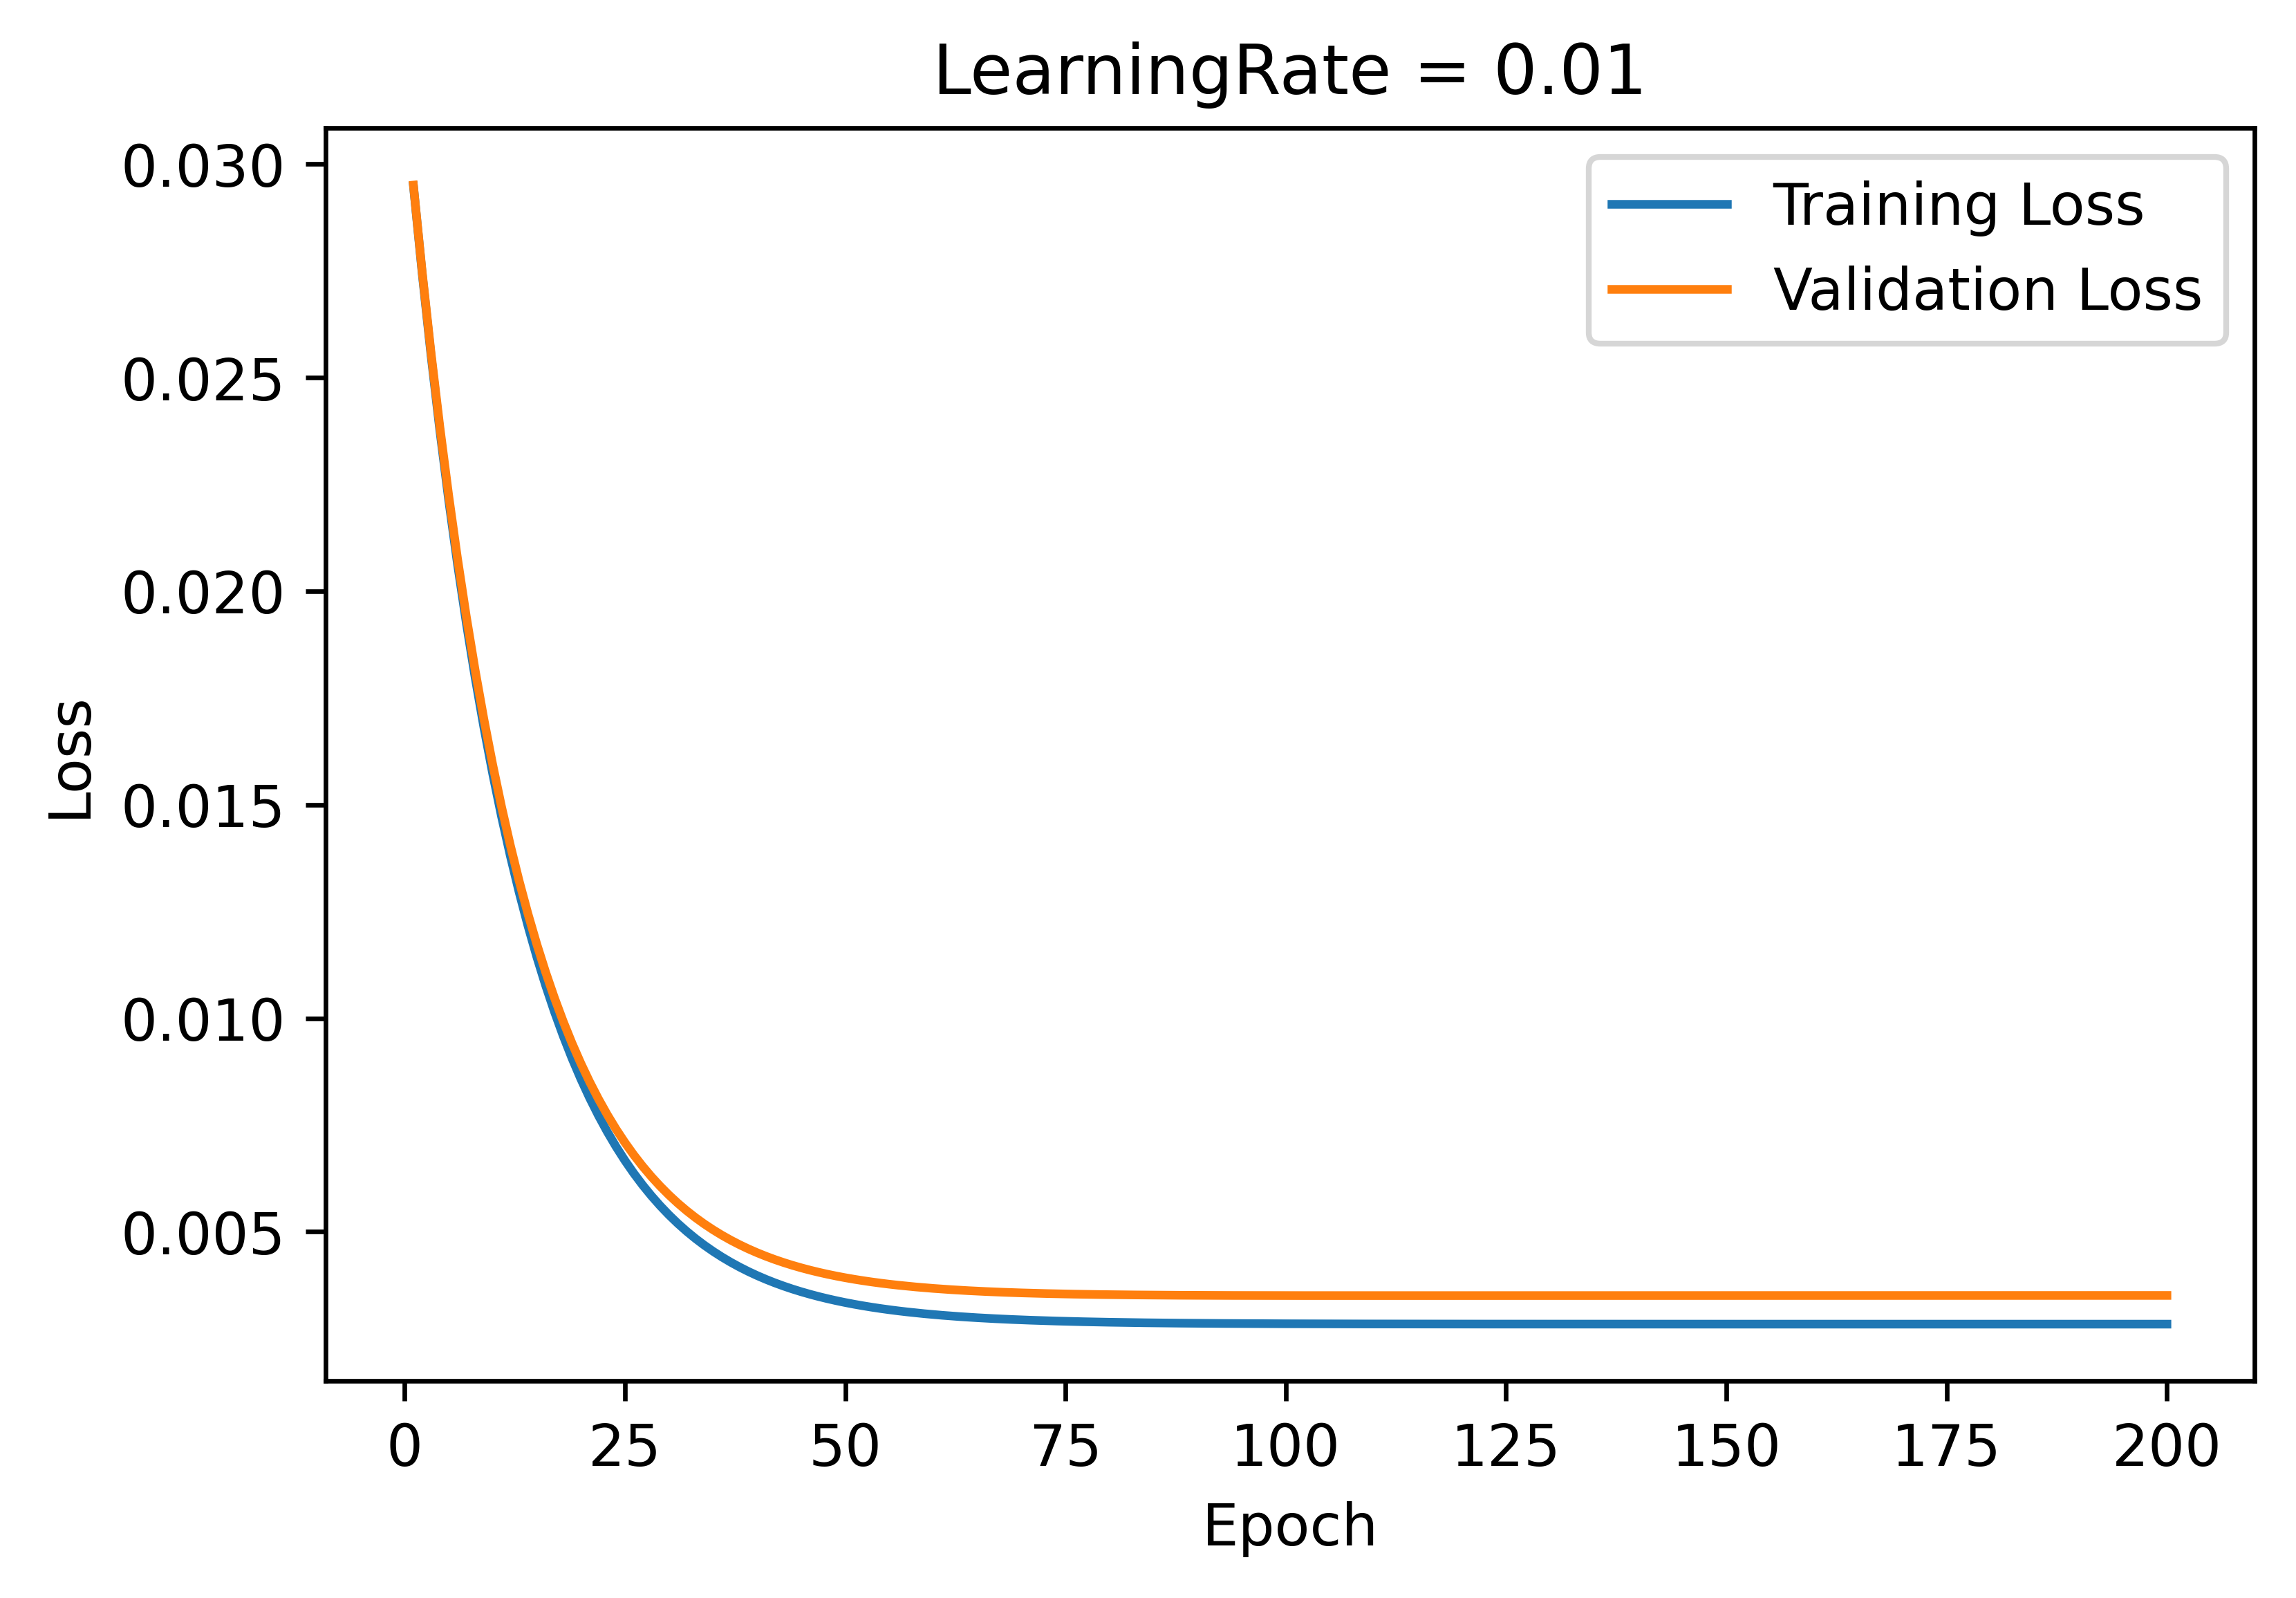

In [12]:
n_epochs = 200

fig= plt.figure(dpi=600)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"LearningRate = {learning_rate}")
plt.plot(range(1, 200 + 1), tloss.detach().numpy(),label='Training Loss')
plt.plot(range(1, 200 + 1), vloss.detach().numpy(),label='Validation Loss')
plt.legend()

In [22]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear_a', nn.Linear(5, 6)),
    ('hidden_activation_a', nn.Tanh()),
    ('hidden_linear_b', nn.Linear(6, 8)),
    ('hidden_activation_b', nn.Tanh()),
    ('hidden_linear_c', nn.Linear(8, 4)),
    ('hidden_activation_c', nn.Tanh()),
    ('output_linear', nn.Linear(4, 1))]))

numel_list = [p.numel() 
              for p in seq_model.parameters()
              if p.requires_grad == True]
print(sum(numel_list), numel_list)

133 [30, 6, 48, 8, 32, 4, 4, 1]


In [14]:
learning_rate=1e-2

optimizer = optim.SGD(seq_model.parameters(), lr=learning_rate)

tloss = torch.ones((200))
vloss = torch.ones((200))

def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        
        t_p_train = model(t_u_train)
        train_loss = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        val_loss = loss_fn(t_p_val, t_c_val)

        tloss[epoch-1] = train_loss
        vloss[epoch-1] = val_loss
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch ==1 or epoch % 200 == 0:
            print(f"Epoch {epoch}, training loss {train_loss.item():.4f},"f" Validation loss {val_loss.item():.4f}")

In [15]:
training_loop(
    n_epochs = 200,
    optimizer = optimizer,
    model =  seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_un,
    t_u_val = val_t_un,
    t_c_train = train_t_c,
    t_c_val = val_t_c)

Epoch 1, training loss 0.1261, Validation loss 0.1252
Epoch 200, training loss 0.0027, Validation loss 0.0034


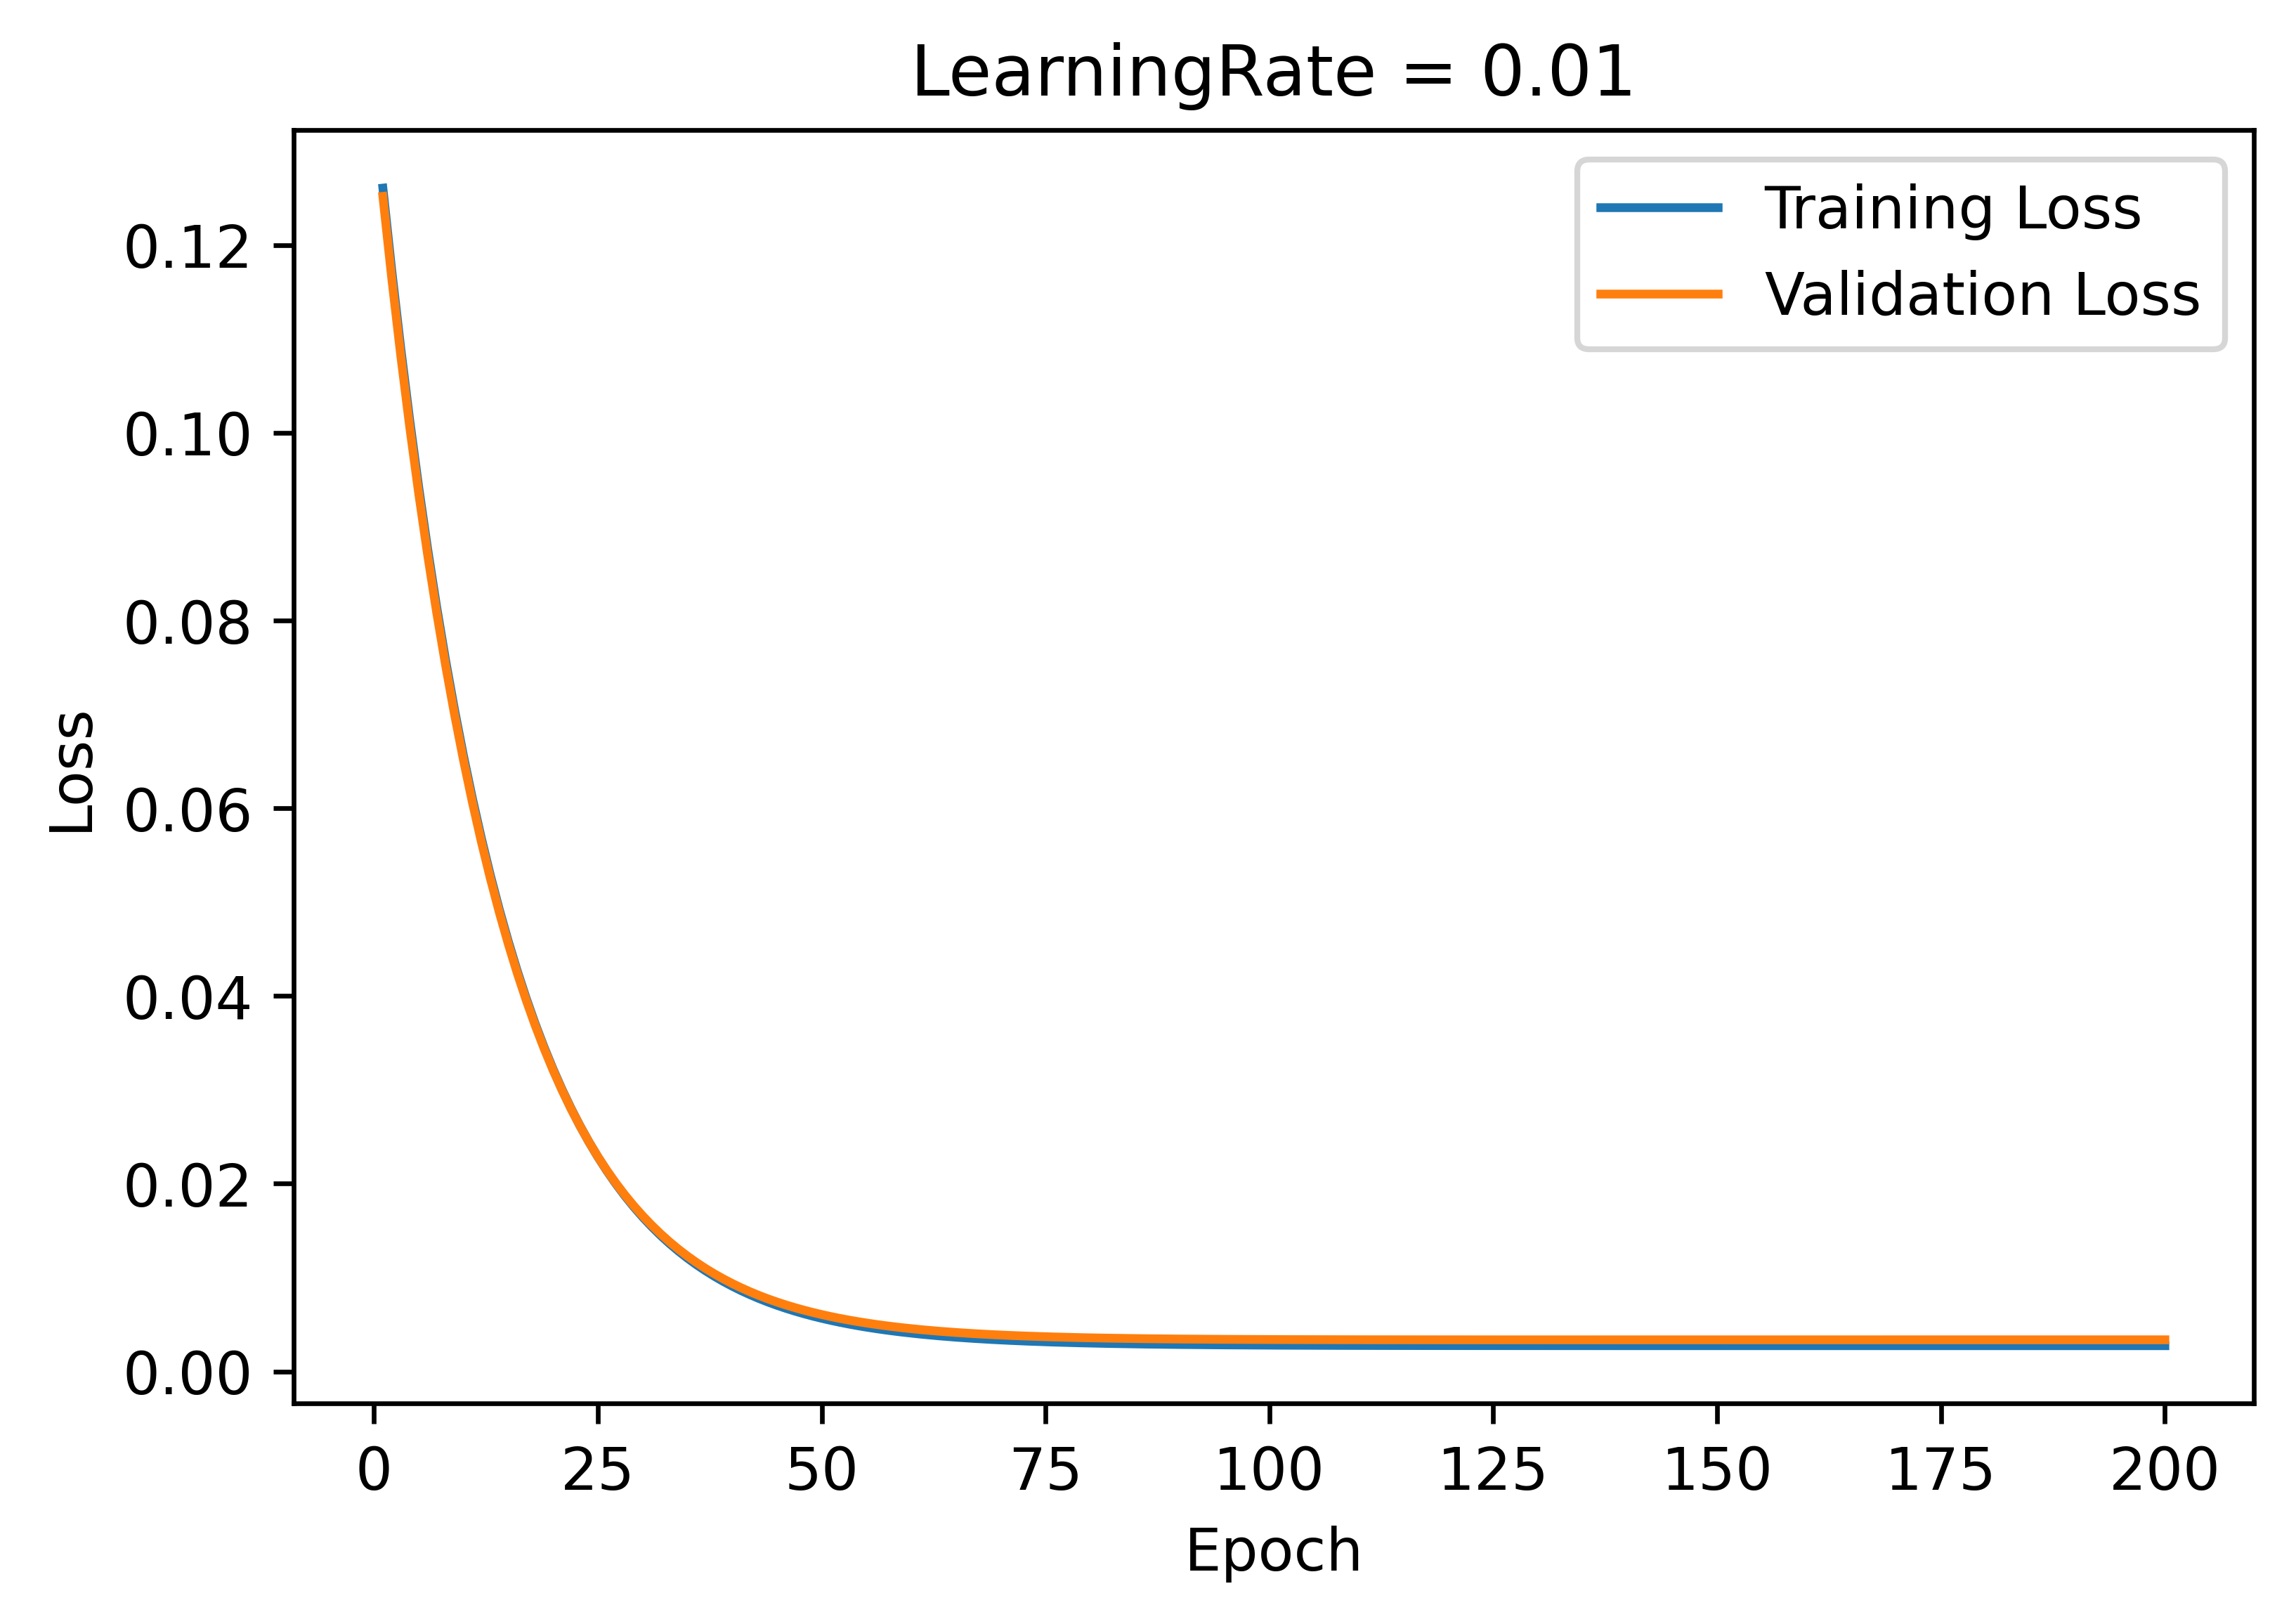

In [16]:
fig= plt.figure(dpi=600)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"LearningRate = {learning_rate}")
plt.plot(range(1, 200 + 1), tloss.detach().numpy(),label='Training Loss')
plt.plot(range(1, 200 + 1), vloss.detach().numpy(),label='Validation Loss')
plt.legend()

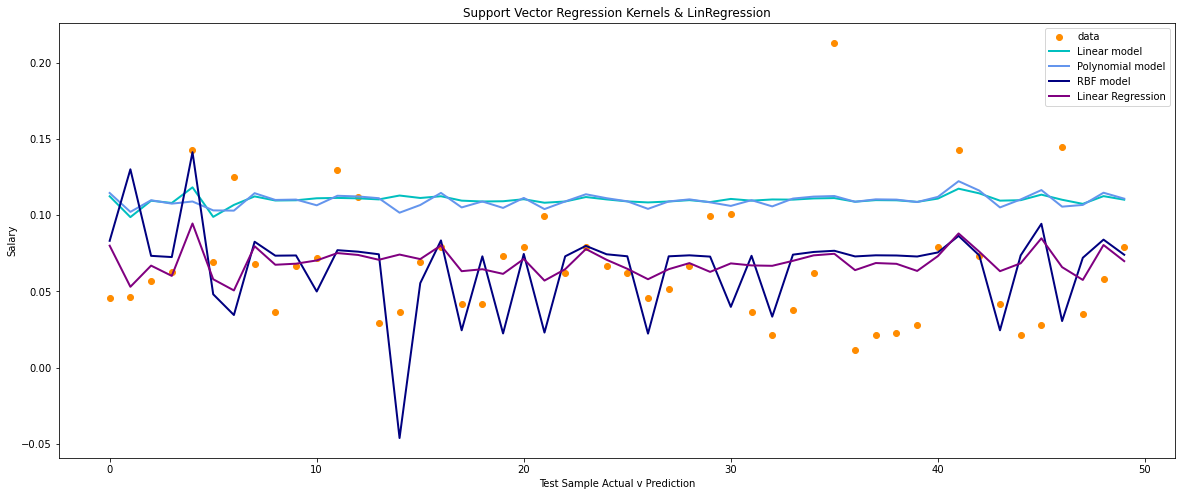

       RBF Kernel gave Mean-Squared-Error of 0.010066325925082746
    Linear Kernel gave Mean-Squared-Error of 0.004087313113776033
      Poly Kernel gave Mean-Squared-Error of 0.004003077856073307
Linear Regression gave Mean-Squared-Error of 0.00208880617655012


In [17]:
import warnings                          #Classical Machine learning methods to compare against the NN
warnings.filterwarnings("ignore")

from sklearn.svm import SVR
from sklearn import metrics
from sklearn.linear_model import LinearRegression

LRmodel = LinearRegression()
svr_rbf = SVR(kernel='rbf', C=1e5, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e4)
svr_poly = SVR(kernel='poly', C=1e4, degree=2)
        
from sklearn.model_selection import train_test_split  #Split data into 80% training and 20% test sets
np.random.seed(0)
X_train, X_test, Y_train, Y_test = train_test_split(X_df,Y_df, test_size = 0.20, random_state=0)

y_rbf = svr_rbf.fit(X_train,Y_train).predict(X_test)
y_lin = svr_lin.fit(X_train,Y_train).predict(X_test)
y_poly = svr_poly.fit(X_train,Y_train).predict(X_test)
y_LR = LRmodel.fit(X_train, Y_train).predict(X_test)

plt.figure(figsize=(20, 8))
lw = 2
numplotpoints = 50
X_data=range(len(X_test[:numplotpoints]))

plt.scatter(X_data[:numplotpoints], Y_test[:numplotpoints], color='darkorange', label='data')
plt.plot(X_data[:numplotpoints],y_lin[:numplotpoints], color='c', lw=lw, label='Linear model')
plt.plot(X_data[:numplotpoints],y_poly[:numplotpoints], color='cornflowerblue', lw=lw, label='Polynomial model')
plt.plot(X_data[:numplotpoints],y_rbf[:numplotpoints], color='navy', lw=lw, label='RBF model')
plt.plot(X_data[:numplotpoints],y_LR[:numplotpoints], color='purple', lw=lw, label='Linear Regression')
plt.xlabel('Test Sample Actual & Prediction')
plt.ylabel('Salary')
plt.title('Support Vector Regression Kernels & LinRegression predictions')
plt.legend()
plt.show()
    
print( "       RBF Kernel gave Mean-Squared-Error of", metrics.mean_squared_error(Y_test, y_rbf))
print( "    Linear Kernel gave Mean-Squared-Error of", metrics.mean_squared_error(Y_test, y_lin))
print( "      Poly Kernel gave Mean-Squared-Error of", metrics.mean_squared_error(Y_test, y_poly))
print( "Linear Regression gave Mean-Squared-Error of", metrics.mean_squared_error(Y_test, y_LR))